In [2]:
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u


import matplotlib.colors as colors
#from astropy.visualization import imshow_norm, MinMaxInterval, LogStretch,PercentileInterval, ImageNormalize

import sep
sys.path.append(os.path.expanduser('~/repos/ReipurthBallyProject/src'))
from catalog import *

sys.path.append(os.path.expanduser('~/repos/runawaysearch/src'))
from gaiastars import gaiastars as gs

## Handy Routines

In [3]:
def add_halpha_to_ax(ax, halpha):
    halpha.plot_hrdiagram(ax=ax, s=40, color='black', marker='*')
    BP_RP, M_G = halpha.get_colors()
    for i, ha in enumerate(halpha.objs.iterrows()):
        ax.annotate(ha[1].Name, xy=(BP_RP.iloc[i], M_G.iloc[i]),
                    xytext=(BP_RP.iloc[i]*1.05, M_G.iloc[i]))

In [4]:
def sky_velocity(gstar):
    mu = np.sqrt(gstar.objs.pmra**2 + gstar.objs.pmdec**2)
    mu_rad = (np.array(mu)*u.mas).to(u.radian).value
    sec = (1*u.year).to(u.second).value
    dist = (np.array(gstar.objs.r_est)*u.pc).to(u.km).value 
    vel = mu_rad*dist/sec

    return vel

In [5]:
# position angles
def pos_angle(pmra, pmdec):
    # degrees east of north
    rad = np.pi/2 - np.arctan2(pmdec, pmra) 
    posangle = np.degrees(np.remainder(2*np.pi+rad, 2*np.pi))
    return posangle

In [6]:
def PosVel_to_pm(posangle, vel, radius):
    # direction and magnitude to proper motion
    # pos angle: degrees east of north
    # vel: km/s
    # radius: pc

    #pos angle to proper angle wrt x-axis

    #radius to km:
    radius_km = (radius*u.pc).to(u.km).value
    theta_deg = np.remainder(90-posangle, 360)
    theta_rad = np.radians(theta_deg)
    omega = (vel/radius_km) #angular velocity,radians per second
    sec_year = (1*u.second).to(u.year) #year per second

    pmra = ((np.cos(theta_rad)*omega)*u.radian).to(u.mas)/sec_year
    pmdec = ((np.sin(theta_rad)*omega)*u.radian).to(u.mas)/sec_year

    return pmra, pmdec

In [7]:
PosVel_to_pm(244.86,	37.59,	3743.58	)

(<Quantity -1.91753393 mas / yr>, <Quantity -0.8998715 mas / yr>)

In [8]:
hh24Eb = SkyCoord(ra='5:46:08.3973',dec='-0:10:00.573', unit=(u.hourangle, u.deg), frame='fk5').icrs

In [9]:
hh24Eb.galactic

<SkyCoord (Galactic): (l, b) in deg
    (205.4770971, -14.5652127)>

## Halpha

In [10]:
Halpha_info = pd.DataFrame(columns=['Name', 'Gaia', 'Parallax', 'Parallax_error'],
                          data = [
['Halpha1',   3219118708937374208,1.1047305185746186, 0.9784005],
['Halpha2',  3219118498484191616, 2.0616781739749666, 0.29806274],
['Halpha3',   3219118498484144512, 3.161310577886153, 0.50830215],
['Halpha4',   3219118429764664832, 2.5633221914251982, 0.4574949],
['Halpha5',   3219117536412592000, 3.8567315506214412, 0.57923716],
])
Halpha_gaia = gs()
Halpha_info.set_index('Gaia', inplace=True)
Halpha_gaia.from_source_idlist(list(Halpha_info.index))
Halpha_gaia.objs = Halpha_gaia.objs.join(Halpha_info)


#calculate sky velocity
Halpha_gaia.objs['SkyVelocity'] = sky_velocity(Halpha_gaia)

# position angle of velocity
Halpha_gaia.objs['PosAngle'] = pos_angle(Halpha_gaia.objs.pmra, Halpha_gaia.objs.pmdec)

#separation from HH24Eb:
Halpha_coords = Halpha_gaia.get_coords()
Halpha_gaia.objs['HH24Sep'] = hh24Eb.separation(Halpha_coords)

Halpha_catalog = Table.from_pandas(Halpha_gaia.objs)
Halpha_catalog.add_index('SOURCE_ID')

Halpha_catalog[['SOURCE_ID', 'Name', 'HH24Sep']]

INFO: Query finished. [astroquery.utils.tap.core]


SOURCE_ID,Name,HH24Sep
int64,bytes1,float64
3219118708937374208,--,0.03692756112551602
3219118498484191616,--,0.03521575026470723
3219118498484144512,--,0.03508959992804347
3219118429764664832,--,0.0243252935711988
3219117536412592000,--,0.023556346975349474


### Red Giant Catalog
From Shonhut-Stasik et. al, 2024

`catalog.dat` below came from (https://cdsarc.cds.unistra.fr/ftp/J/AJ/167/50/) which apparently is a stale catalog.  Contacting paper's lead author: jessica.s.stasik@vanderbilt.edu, supplied via email the most recent version of the catalog which is used below.

In [11]:
#stale catalog
#rg_tbl = load_catalog('/home/kevin/Documents/HH24/schonhut-stasik/red_giant_catalog.xml')

#corrected catalog
rg_tbl=pd.read_csv('/home/kevin/Documents/HH24/schonhut-stasik/apok2_compiled_dec20.csv', low_memory=False)
rg_gaia = gs()
rg_gaia.from_source_idlist(rg_tbl['gaia_source'])

#ditch the gaia records with negative parallax:
br = np.where(rg_gaia.objs.parallax <=0)[0]
labels = rg_gaia.objs.index[br]
rg_gaia.objs.drop(labels=labels, inplace=True)


INFO: Query finished. [astroquery.utils.tap.core]


In [12]:

#calculate sky velocity
rg_gaia.objs['SkyVelocity'] = sky_velocity(rg_gaia)

# position angle of velocity
rg_gaia.objs['PosAngle'] = pos_angle(rg_gaia.objs.pmra, rg_gaia.objs.pmdec)

#separation from HH24Eb:
rg_coords = rg_gaia.get_coords()
rg_gaia.objs['HH24Sep'] = hh24Eb.separation(rg_coords).value

# grab the ev column and put it on the table
ev_s = rg_tbl[['gaia_source','ev']].set_index('gaia_source')
rg_gaia.objs = pd.merge(rg_gaia.objs,ev_s, left_index=True, right_index=True, how='left')
rg_gaia.objs.rename({'ev_x':'ev'}, inplace=True)

rg_catalog = Table.from_pandas(rg_gaia.objs)
rg_catalog.add_index('SOURCE_ID')

for c in rg_catalog.columns:
    if c in ['SOURCE_ID', 'ev'] : continue
    rg_catalog[c].info.format='.2f'

In [13]:
HH24_neighbors = rg_catalog['HH24Sep'] <=20
rg_catalog[HH24_neighbors][['SOURCE_ID','r_est','phot_g_mean_mag','phot_rp_mean_mag','SkyVelocity','PosAngle','HH24Sep', 'ev']]

SOURCE_ID,r_est,phot_g_mean_mag,phot_rp_mean_mag,SkyVelocity,PosAngle,HH24Sep,ev
int64,float64,float32,float32,float64,float64,float64,bytes1
3393981396087385216,3743.58,14.34,13.55,37.59,244.86,18.38,--
3394744525877193728,1668.67,11.49,10.69,8.14,158.45,18.73,--
3394651960741320064,1646.35,11.78,11.03,8.50,151.79,18.79,--
3393815163673474560,803.19,11.95,11.09,49.21,197.64,17.90,--
3394761804528747008,1617.01,12.09,11.35,8.00,153.81,19.00,--
3394596740347200512,1045.05,12.15,11.34,80.47,93.99,18.53,--
3394781836256227328,1818.61,12.22,11.47,9.12,156.31,18.86,--
3394859974597564800,1359.16,12.47,11.67,17.63,152.21,19.48,--
3392987128338034944,841.05,10.81,9.96,13.62,114.88,18.72,--


In [14]:
len(rg_catalog)

7661

In [15]:
rg_catalog['HH24Sep'].min()

17.47576943300581

In [16]:
# test pmra pmdec from skyvelocity and posangle
pmra, pmdec = PosVel_to_pm(rg_catalog['PosAngle'], rg_catalog['SkyVelocity'], rg_catalog['r_est'])

pd.DataFrame({"ActualPMRA":rg_catalog['pmra'],'PredPMRA': pmra,
              'ActualPMDEC': rg_catalog['pmdec'], 'PredPMDEC':pmdec})

,ActualPMRA,PredPMRA,ActualPMDEC,PredPMDEC
0,-6.500417,-6.500417,-16.426417,-16.426417
1,-1.399924,-1.399924,-1.798552,-1.798552
2,-1.613530,-1.613530,-1.528874,-1.528874
3,0.459585,0.459585,-0.427672,-0.427672
4,0.281262,0.281262,-0.046624,-0.046624
...,...,...,...,...
7656,-7.963907,-7.963907,-7.666834,-7.666834
7657,-9.648215,-9.648215,-15.423265,-15.423265
7658,7.551483,7.551483,-11.230252,-11.230252
7659,-0.122003,-0.122003,-8.527180,-8.527180


## Candidate Brown Dwarfs

In [17]:
objcat = load_catalog('/home/kevin/Documents/HH24/matchcat/objvelocity.xml', index_col='objid')
pmra, pmdec = PosVel_to_pm(objcat['PosAngle'].value, objcat['Velocity'].value, objcat['Distance'].value)
objcat['pmra'] = pmra
objcat['pmdec'] = pmdec

In [18]:
objcat

objid,RA_2024_,Dec_2024_,RA_2009_,Dec_2009_,PM,Separation,Distance,PosAngle,Velocity,Vel_Err,pmra,pmdec
,,,,,mas / yr,arcsec,pc,deg,km / s,km / s,mas / yr,mas / yr
str8,str11,str11,str11,str11,float64,float64,float64,float64,float64,float64,float64,float64
obj-0002,5:46:05.380,-0:11:03.99,5:46:05.382,-0:11:04.02,2.858691049552455,0.04122248182132834,399.99999999999994,317.8297951331548,5.4206161939082245,3.1505888679252703,-1.919140107466125,2.1187297526362894
obj-0003,5:46:05.359,-0:10:57.97,5:46:05.361,-0:10:58.03,5.201590226160325,0.0750072165278099,399.99999999999994,329.89729628766304,9.863193932206707,3.5993747147593043,-2.608865702588894,4.500040069459602
obj-0004,5:46:05.714,-0:10:49.86,5:46:05.716,-0:10:49.90,3.316358792507963,0.047822075791843416,399.99999999999994,329.8825716828173,6.2884403609452475,3.3195935763815827,-1.6640622089268091,2.8686464762090336
obj-0057,5:46:07.559,-0:09:35.82,5:46:07.572,-0:09:35.86,14.703150795084737,0.21202024138338366,399.99999999999994,281.038507470614,27.879940825990428,4.789661327171855,-14.431123721217459,2.815192967793828
IRS-1,5:46:07.763,-0:09:38.00,5:46:07.763,-0:09:38.00,0.5316941117871229,0.00766705827168114,399.99999999999994,117.98312693099271,1.0081920930245818,2.4702632858293856,0.46953152513343605,-0.24947700377984186
obj-0073,5:46:08.211,-0:10:45.31,5:46:08.221,-0:10:45.21,12.642790530680825,0.18230973329679825,399.99999999999994,234.26717652375223,23.973110034932624,4.422609297699818,-10.262773782752836,-7.383469827033482
obj-0077,5:46:07.997,-0:10:03.72,5:46:08.032,-0:10:04.31,54.6692821165854,0.7883340484061148,399.99999999999994,318.2874004568038,103.663246854498,11.852178712572165,-36.37664111144891,40.810175062006905
obj-0088,5:46:08.024,-0:09:48.99,5:46:07.982,-0:09:48.33,63.12494287951294,0.9102651406595674,399.99999999999994,136.16272477142238,119.69677089302435,13.553606478428758,43.72112998325062,-45.53263891462341


### YSO Catalog
From Fang, et. al. 2009

In [19]:
yso_tbl = load_catalog('/home/kevin/Documents/HH24/Fang2009/yso_catalog.xml')
yso_gaia = gs()
yso_gaia.from_source_idlist(yso_tbl['GaiaDR3'])

#calculate sky velocity
yso_gaia.objs['SkyVelocity'] = sky_velocity(yso_gaia)

# position angle of velocity
yso_gaia.objs['PosAngle'] = pos_angle(yso_gaia.objs.pmra, yso_gaia.objs.pmdec)

#separation from HH24Eb:
yso_coords = yso_gaia.get_coords()
yso_gaia.objs['HH24Sep'] = hh24Eb.separation(yso_coords)

yso_catalog = Table.from_pandas(yso_gaia.objs)
yso_catalog.add_index('SOURCE_ID')

for c in yso_catalog.columns:
    if c == 'SOURCE_ID': continue
    yso_catalog[c].info.format='.2f'

yso_catalog[['SOURCE_ID','phot_g_mean_mag', 'r_est','SkyVelocity','PosAngle','HH24Sep']]

INFO: Query finished. [astroquery.utils.tap.core]


SOURCE_ID,phot_g_mean_mag,r_est,SkyVelocity,PosAngle,HH24Sep
int64,float32,float64,float64,float64,float64
3219171107539228032,16.18,412.96,1.82,152.34,0.25
3219113378882611968,17.08,414.29,1.31,146.25,0.20
3219198870207817856,15.49,414.65,1.78,232.66,0.33
3219121045400432256,15.76,415.71,2.04,132.66,0.13
3219123038265248128,15.99,421.13,1.32,165.46,0.15
3219116544274710912,14.27,404.16,1.67,122.47,0.12
3219170553487486080,17.60,420.66,1.76,204.42,0.18
3219222028671353344,14.93,414.82,3.13,223.18,0.56
3219119907233300608,18.09,479.93,2.12,137.00,0.10


Text(0, 0.5, 'Number of YSO')

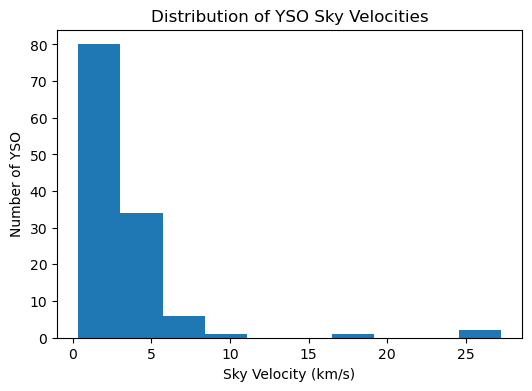

In [20]:
fig, ax = plt.subplots(figsize=(6,4))
zz=ax.hist(yso_catalog['SkyVelocity'])
ax.set_title('Distribution of YSO Sky Velocities')
ax.set_xlabel('Sky Velocity (km/s)')
ax.set_ylabel('Number of YSO')

In [21]:
# any of the Halphas in the YSO list?
yso_list = set(yso_catalog['SOURCE_ID'])
halpha_list = set(Halpha_gaia.objs.index)

common = yso_list.intersection(halpha_list)
Halpha_gaia.objs.loc[list(common)][['SOURCE_ID','Name', 'SkyVelocity']]

,SOURCE_ID,Name,SkyVelocity


In [22]:
hh24Eb = SkyCoord(ra='5:46:08.3973',dec='-0:10:00.573', unit=(u.hourangle, u.deg))
hh24Eb_cone = gs()
# hh24Eb_cone.gaia_source_constraints= [
#     '{schema}.gaia_source.source_id is not Null']
hh24Eb_cone.conesearch(hh24Eb.ra,hh24Eb.dec,3*u.deg)
print(f'Cone Search returned {len(hh24Eb_cone.objs)} objects')

INFO: Query finished. [astroquery.utils.tap.core]
Cone Search returned 44555 objects


In [23]:
hh24Eb_cone.tap_query_string

"SELECT  gaiaedr3.gaia_source.source_id, gaiaedr3.gaia_source.ra, gaiaedr3.gaia_source.dec, gaiaedr3.gaia_source.parallax, gaiaedr3.gaia_source.pmra, gaiaedr3.gaia_source.pmdec, gaiaedr3.gaia_source.dr2_radial_velocity, gaiaedr3.gaia_source.phot_g_mean_mag, gaiaedr3.gaia_source.phot_bp_mean_mag, gaiaedr3.gaia_source.phot_rp_mean_mag, gaiaedr3.gaia_source.ruwe FROM gaiaedr3.gaia_source WHERE CONTAINS(POINT('', ra, dec),  CIRCLE('', 86.53498875, -0.1668258333333333, 3.0)) = 1  AND gaiaedr3.gaia_source.parallax_over_error > 10 AND gaiaedr3.gaia_source.phot_g_mean_flux_over_error>50 AND gaiaedr3.gaia_source.phot_rp_mean_flux_over_error>20 AND gaiaedr3.gaia_source.phot_bp_mean_flux_over_error>20 AND gaiaedr3.gaia_source.phot_bp_rp_excess_factor < 1.3+0.06*power(gaiaedr3.gaia_source.phot_bp_mean_mag-gaiaedr3.gaia_source.phot_rp_mean_mag,2) AND gaiaedr3.gaia_source.phot_bp_rp_excess_factor > 1.0+0.015*power(gaiaedr3.gaia_source.phot_bp_mean_mag-gaiaedr3.gaia_source.phot_rp_mean_mag,2) AND gai

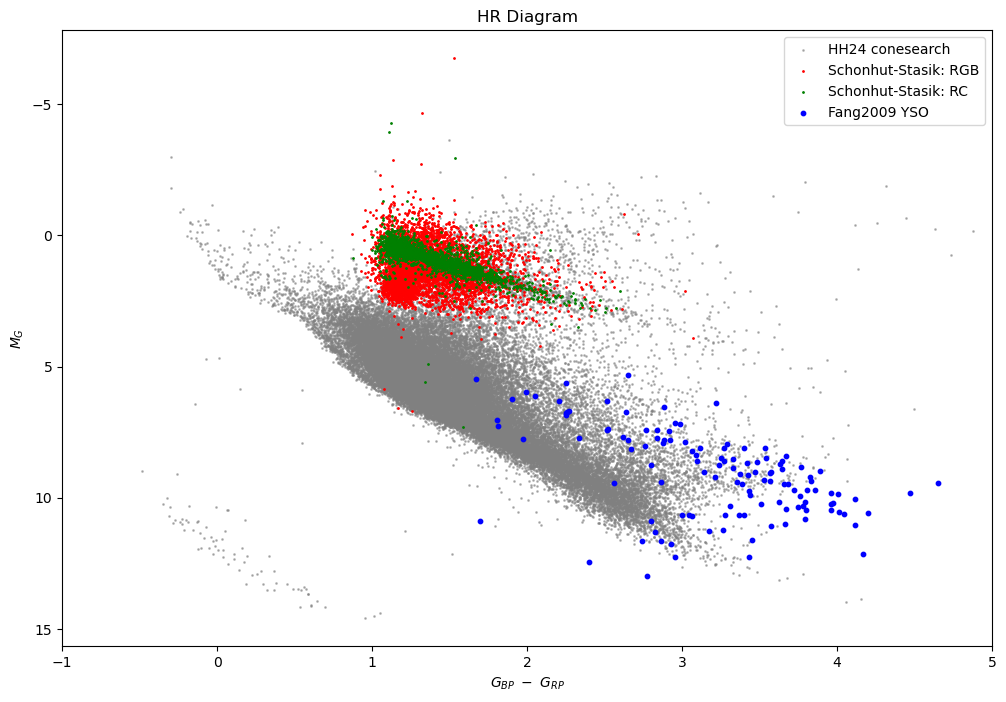

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
hh24Eb_cone.plot_hrdiagram  (ax=ax, color='gray',alpha=0.5, label='HH24 conesearch')
rg_gaia.query('ev == \'RGB\'').plot_hrdiagram(ax=ax, color='red', label='Schonhut-Stasik: RGB')
rg_gaia.query('ev == \'RC\'').plot_hrdiagram(ax=ax, color='green', label = 'Schonhut-Stasik: RC')
yso_gaia.plot_hrdiagram(ax=ax, color='blue', s=10, label='Fang2009 YSO')
ax.legend()

# 1. Estimate Cloud Motion

## Exclude Halpha5 and Obvious Outliers

From histogram above, outliers are anything above 13 km/s

In [27]:
ha5_source_id = Halpha_catalog[Halpha_catalog['Name']=='Halpha5']['SOURCE_ID']
vel_cutoff = 13 # km/s

outliers = np.logical_or(yso_catalog['SOURCE_ID']==ha5_source_id, yso_catalog['SkyVelocity'] >= vel_cutoff)
yso_catalog[outliers][['SOURCE_ID','r_est','SkyVelocity','PosAngle','HH24Sep']]

SOURCE_ID,r_est,SkyVelocity,PosAngle,HH24Sep
int64,float64,float64,float64,float64
3219117536412592000,259.29,16.86,125.42,0.02
3219207494502113792,184.96,24.80,177.06,0.44
3219209861029037952,269.77,27.24,163.80,0.51


In [28]:
row_i = np.arange(len(yso_catalog))[outliers]

yso_catalog.remove_rows(row_i)

In [32]:
BDs = ['BD1', 'BD2', 'BD3']
bdcat = objcat.loc[BDs]
bdcat

objid,RA_2024_,Dec_2024_,RA_2009_,Dec_2009_,PM,Separation,Distance,PosAngle,Velocity,Vel_Err,pmra,pmdec
,,,,,mas / yr,arcsec,pc,deg,km / s,km / s,mas / yr,mas / yr
str8,str11,str11,str11,str11,float64,float64,float64,float64,float64,float64,float64,float64
BD1,5:46:09.945,-0:10:11.00,5:46:09.929,-0:10:10.96,16.668787857136092,0.24036483569357558,399.99999999999994,99.71122715860297,31.607158599862785,5.006775921878748,16.429931370105272,-2.811733237673578
BD2,5:46:12.233,-0:10:55.32,5:46:12.202,-0:10:55.27,32.78753735070092,0.47279808799799866,399.99999999999994,95.9344861101809,62.17134095319767,7.843222461992765,32.611821282373654,-3.3899436824421287
BD3,5:46:13.333,-0:10:36.95,5:46:13.326,-0:10:36.81,12.002899406572112,0.17308246816951897,399.99999999999994,143.90996095004755,22.759756045446824,4.408720385220154,7.070378452057986,-9.699450639544661


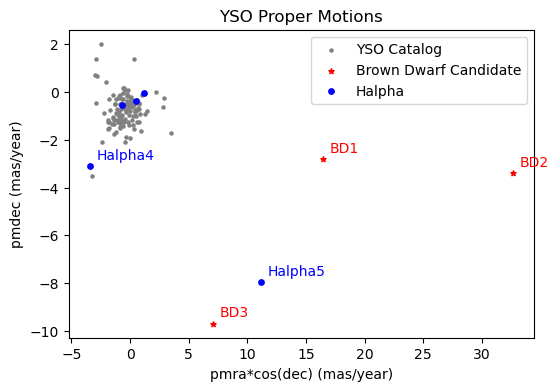

In [73]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(yso_catalog['pmra'], yso_catalog['pmdec'], s=5, color='gray', label='YSO Catalog',alpha=1.0)
ax.scatter(bdcat['pmra'], bdcat['pmdec'], s=15, marker='*', color='red', label='Brown Dwarf Candidate')
ax.scatter(Halpha_catalog['pmra'], Halpha_catalog['pmdec'], color='blue', s=15, label='Halpha')

for bd in bdcat:
    ax.annotate(bd['objid'], (bd['pmra'], bd['pmdec']),xytext=(5,5),
                textcoords='offset points', color='red')
    
for bd in Halpha_catalog:
    if bd['Name'] in ['Halpha4', 'Halpha5']:
        ax.annotate(bd['Name'], (bd['pmra'], bd['pmdec']),xytext=(5,5),
                    textcoords='offset points', color='blue')

ax.set_title('YSO Proper Motions')
ax.set_xlabel('pmra*cos(dec) (mas/year)')
ax.set_ylabel('pmdec (mas/year)')
ax.legend()

make a weighted mean of the 132 proper motions (probably after removing a few obvious outliers, including Halpha 5). This gives the cloud motion. 

In [74]:
#weighted how??
N_yso = len(yso_catalog)

yso_pmra = yso_catalog['pmra'].mean()
yso_pmra_std = yso_catalog['pmra'].std()

yso_pmdec = yso_catalog['pmdec'].mean()
yso_pmdec_std = yso_catalog['pmdec'].std()

print(f'PM RA: {yso_pmra:.2f} mas/year +/- {yso_pmra_std/np.sqrt(N_yso):.2f} mas/year')
print(f'PM Dec: {yso_pmdec:.2f} mas/year +/- {yso_pmdec_std/np.sqrt(N_yso):.2f} mas/year')

PM RA: -0.47 mas/year +/- 0.10 mas/year
PM Dec: -0.74 mas/year +/- 0.06 mas/year


# 2. Motion of BD1,BD2, BD3 Halpha5 in Frame of Cloud

 Subtract the cloud motion from BD1, BD2, BD3, and Ha5. This gives the motion of these objects within a stationary cloud, that is, relative to the SSV63 stars (to within a few km/s)

 Naming convention: pmra_SSV63 to designate wrt SSV63

In [53]:
pmra = objcat['pmra_SSV63'] = objcat['pmra'] - yso_pmra
pmdec = objcat['pmdec_SSV63'] = objcat['pmdec'] - yso_pmdec

mu = np.sqrt(pmra**2 + pmdec**2)
mu_rad = (np.array(mu)*u.mas).to(u.radian).value
sec = (1*u.year).to(u.second)
dist = objcat['Distance'].to(u.km)
vel = mu_rad*dist/sec

objcat['Velocity_SSV63'] = vel
objcat['PosAngle_SSV63'] = pos_angle(pmra, pmdec)


In [66]:
halphas = ['Halpha5']
cols =['objid',
 'Distance',
 'PosAngle',
 'Velocity',
 'Vel_Err',
 'pmra',
 'pmdec',
 'pmra_SSV63',
 'pmdec_SSV63',
 'Velocity_SSV63', 'PosAngle_SSV63']

for c in cols:
    if c=='objid':continue
    objcat[c].info.format='.2f'

objcat.loc[BDs+halphas][cols]

objid,Distance,PosAngle,Velocity,Vel_Err,pmra,pmdec,pmra_SSV63,pmdec_SSV63,Velocity_SSV63,PosAngle_SSV63
,pc,deg,km / s,km / s,mas / yr,mas / yr,mas / yr,mas / yr,km / s,mas / yr
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
BD1,400.00,99.71,31.61,5.01,16.43,-2.81,16.90,-2.08,32.29,97.00
BD2,400.00,95.93,62.17,7.84,32.61,-3.39,33.09,-2.65,62.94,94.59
BD3,400.00,143.91,22.76,4.41,7.07,-9.70,7.54,-8.96,22.21,139.91
Halpha5,400.00,125.79,23.60,4.43,10.09,-7.28,10.57,-6.54,23.57,121.76
